In [1]:
!pip install kaggle opencv-python tensorflow pandas scikit-learn

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:

# Install Kaggle package
!pip install kaggle

# Create a directory for the Kaggle API token and move the token file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle setup
!kaggle datasets list

# Download the dataset
!kaggle datasets download -d danialsharifrazi/cad-cardiac-mri-dataset

# Unzip the dataset
!unzip cad-cardiac-mri-dataset.zip -d dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sick/Directory_26/SR_57/IM00059.jpg  
  inflating: dataset/Sick/Directory_26/SR_57/IM00060.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00001.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00002.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00003.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00004.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00005.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00006.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00007.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00008.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00009.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00010.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00011.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00012.jpg  
  inflating: dataset/Sick/Directory_26/SR_58/IM00013.jpg  
  inflating: dataset/Sick/Directory_26/SR_59/IM00001.jpg  
  inf

In [4]:
import os
import cv2
import numpy as np

# Set paths for the dataset
normal_dir = 'dataset/Normal'
sick_dir = 'dataset/Sick'

# Function to load images
def load_images(directory, label):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Check if the image was loaded successfully
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                continue

            img = cv2.resize(img, (128, 128))  # Resize to 128x128
            images.append(img)
            labels.append(label)
    return images, labels




# Load Normal and Sick images
normal_images, normal_labels = load_images(normal_dir, 0)
sick_images, sick_labels = load_images(sick_dir, 1)

# Combine Normal and Sick images
images = np.array(normal_images + sick_images)
labels = np.array(normal_labels + sick_labels)

# Normalize images
images = images / 255.0

# Add a channel dimension (for grayscale images)
images = np.expand_dims(images, axis=-1)

print(f"Loaded and preprocessed {len(images)} images.")

Loaded and preprocessed 63425 images.


Normal Images:


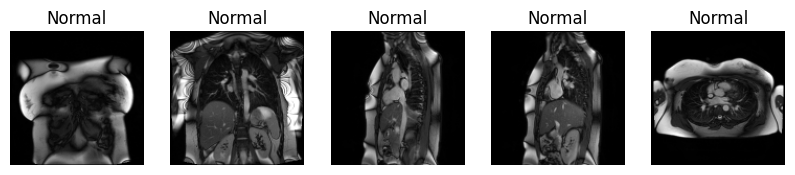

Sick Images:


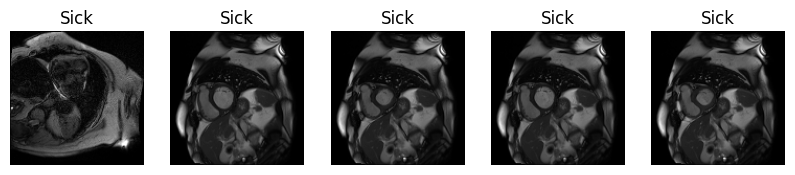

In [6]:
import matplotlib.pyplot as plt

def plot_sample_images(images, labels, class_names, num_samples=5, class_to_plot=None):
    plt.figure(figsize=(10, 5))

    # Filter images and labels by the specified class
    if class_to_plot is not None:
        indices = [i for i, label in enumerate(labels) if label == class_to_plot]
        images = [images[i] for i in indices]
        labels = [labels[i] for i in indices]

    for i in range(min(num_samples, len(images))):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.show()

# Class names
class_names = ['Normal', 'Sick']

# Plot normal images
print("Normal Images:")
plot_sample_images(images, labels, class_names, class_to_plot=0)

# Plot sick images
print("Sick Images:")
plot_sample_images(images, labels, class_names, class_to_plot=1)


<ipython-input-7-76dc65c86a56>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='viridis')


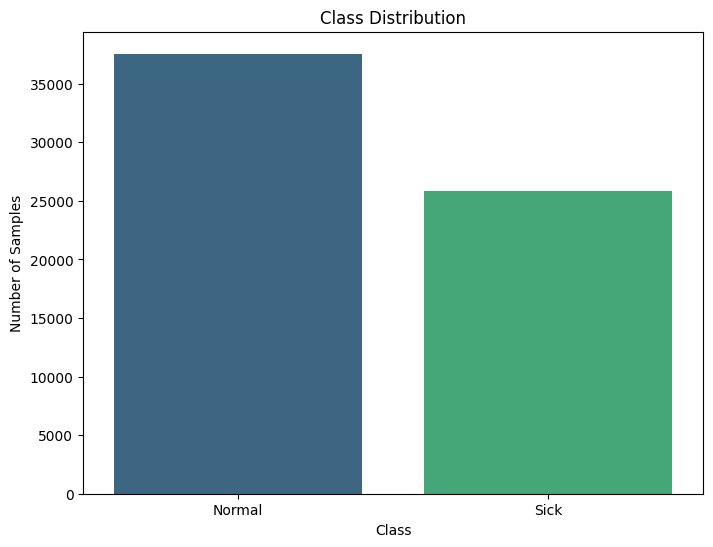

In [7]:
import seaborn as sns

def plot_class_distribution(labels, class_names):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=labels, palette='viridis')
    plt.xticks(ticks=[0, 1], labels=class_names)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

plot_class_distribution(labels, class_names)


In [8]:
normal_images, normal_labels = load_images(normal_dir, 0)
sick_images, sick_labels = load_images(sick_dir, 1)

print(f"Normal images: {len(normal_images)}")
print(f"Sick images: {len(sick_images)}")


Normal images: 37564
Sick images: 25861


In [9]:
images = np.array(normal_images + sick_images)
labels = np.array(normal_labels + sick_labels)

print(f"Type of images: {type(images)}")
print(f"Type of labels: {type(labels)}")


Type of images: <class 'numpy.ndarray'>
Type of labels: <class 'numpy.ndarray'>


In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding (for classification)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

print(f"Train labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")


Train labels shape: (50740, 2)
Validation labels shape: (12685, 2)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer with 2 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,  # Adjust the number of epochs as needed
    batch_size=32,
    validation_data=(X_val, y_val)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.8195 - loss: 1.7700 - val_accuracy: 0.9573 - val_loss: 0.1091
Epoch 2/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9563 - loss: 0.1152 - val_accuracy: 0.9682 - val_loss: 0.0769
Epoch 3/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9739 - loss: 0.0741 - val_accuracy: 0.9779 - val_loss: 0.0566
Epoch 4/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9769 - loss: 0.0656 - val_accuracy: 0.9756 - val_loss: 0.0672
Epoch 5/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9802 - loss: 0.0546 - val_accuracy: 0.9835 - val_loss: 0.0447


In [12]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9835 - loss: 0.0432
Validation Loss: 0.04473419487476349
Validation Accuracy: 0.9835238456726074


In [13]:
# Save the model
model.save('cardiovascular_disease_model.h5')


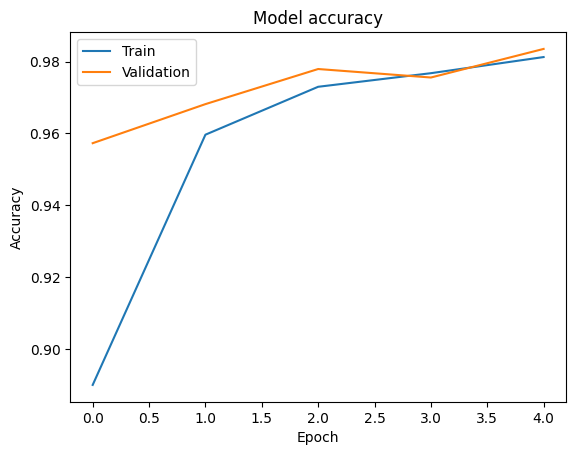

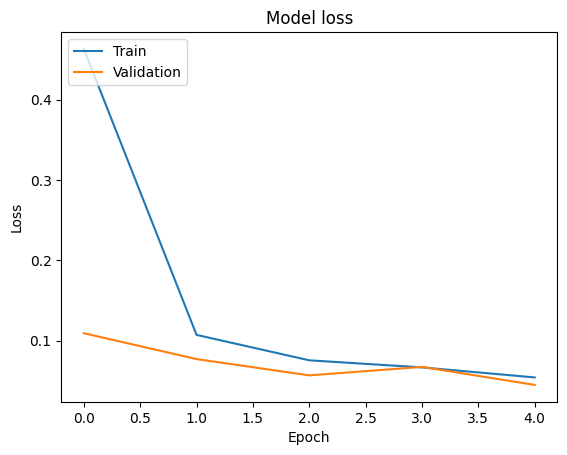

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


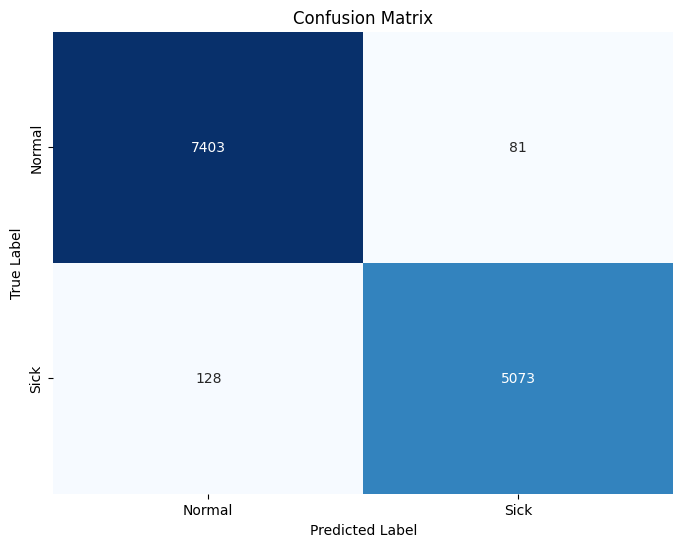

In [17]:
# prompt: plot_confusion_matrix

from sklearn.metrics import confusion_matrix

# Predict classes for validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded validation labels to class labels
y_true_classes = np.argmax(y_val, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Sick'])
print(report)


397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99      7484
        Sick       0.98      0.98      0.98      5201

    accuracy                           0.98     12685
   macro avg       0.98      0.98      0.98     12685
weighted avg       0.98      0.98      0.98     12685

